In [1]:
import pandas as pd
import numpy as np
import librosa
import os
import torch.nn as nn
import pickle
import librosa.display
from tqdm import tqdm_notebook as tqdm
from PIL import Image
import matplotlib.pyplot as plt
import random
os.listdir('../input')

['train_noisy.csv',
 'test',
 'train_curated',
 'train_noisy',
 'sample_submission.csv',
 'train_curated.csv']

In [2]:
class config:
    PATH = '../input'
    csv  = {'train_curated': os.path.join(PATH, 'train_curated.csv'),
             'train_noisy':os.path.join(PATH, 'train_noisy.csv'),
             'test':os.path.join(PATH, 'sample_submission.csv')}
    dataset = {'train_curated': os.path.join(PATH, 'train_curated'),
                'train_noisy':os.path.join(PATH, 'train_noisy'),
                'test':os.path.join(PATH, 'test')}
    sampling_rate = 44100
    duration = 2 # sec
    hop_length = 347*duration # to make time steps 128
    fmin = 20
    fmax = sampling_rate // 2
    n_mels = 128
    n_fft = n_mels * 20
    padmode = 'constant'
    samples = sampling_rate * duration

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

In [4]:
train_curated = pd.read_csv(config.csv['train_curated'])
train_noisy = pd.read_csv(config.csv['train_noisy'])
test = pd.read_csv(config.csv['test'])

In [5]:
TARGETS = list(test.columns[1:])

In [6]:
train_curated.head()

,fname,labels
0,0006ae4e.wav,Bark
1,0019ef41.wav,Raindrop
2,001ec0ad.wav,Finger_snapping
3,0026c7cb.wav,Run
4,0026f116.wav,Finger_snapping


In [7]:
train_noisy.head()

,fname,labels
0,00097e21.wav,Bathtub_(filling_or_washing)
1,000b6cfb.wav,Motorcycle
2,00116cd2.wav,"Marimba_and_xylophone,Glockenspiel"
3,00127d14.wav,"Water_tap_and_faucet,Sink_(filling_or_washing)"
4,0019adae.wav,Raindrop


In [8]:
len(train_noisy)

19815

In [9]:
def envelope(y, rate, threshold):
    
    mask = []
    y = pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/10), min_periods=1, center=True).mean()
    for mean in y_mean:
        if mean > threshold:
            mask.append(True)
        else:
            mask.append(False)
            
    return mask
    
def spectrogram_to_color(X, mean=None, std=None, norm_max=None, norm_min=None, eps=1e-6):
    # Stack X as [X,X,X]
    X = np.stack([X, X, X], axis=-1)

    # Standardize
    mean = mean or X.mean()
    std = std or X.std()
    Xstd = (X - mean) / (std + eps)
    _min, _max = Xstd.min(), Xstd.max()
    norm_max = norm_max or _max
    norm_min = norm_min or _min
    if (_max - _min) > eps:
        V = Xstd
        V[V < norm_min] = norm_min
        V[V > norm_max] = norm_max
        V = 255 * (V - norm_min) / (norm_max - norm_min)
        V = V.astype(np.uint8)
    else:
        V = np.zeros_like(Xstd, dtype=np.uint8)
    return V

def extract_melspectrogram(path, display=False):
    wave, sr = librosa.load(path, sr=config.sampling_rate)
    #mask = envelope(wave, sr, threshold=0.0005)
    #wave = wave[mask]
    if 0 < len(wave):  # workaround: 0 length causes error
        wave , _ = librosa.effects.trim(wave)
    if len(wave) < config.samples:
        padding = config.samples - len(wave)    # add padding at both ends
        offset = padding // 2
        wave = np.pad(wave, (offset, config.samples - len(wave) - offset), config.padmode)

    melspectrogram = librosa.feature.melspectrogram(wave, sr, n_fft=config.n_fft,
                                                    hop_length=config.hop_length,
                                                    n_mels=config.n_mels, fmin=config.fmin,
                                                    fmax=config.fmax)
    melspectrogram = librosa.power_to_db(melspectrogram)
    melspectrogram = melspectrogram.astype(np.float32)

    if display:
        librosa.display.specshow(melspectrogram, y_axis='mel', x_axis='time')

    return spectrogram_to_color(melspectrogram)

def create_mel_inputs(df, dataset, check=False, num=False):
    
    output = []
    for i in tqdm(range(len(df))):
        
        path = os.path.join(config.dataset[dataset], df.loc[i, 'fname'])
        melspectrogram = extract_melspectrogram(path, display=check)
        
        if check:
            plt.figure()
            img = Image.fromarray(melspectrogram)
            img = np.asarray(img)
            plt.imshow(img)
        
        output.append(melspectrogram)
        
    if num:
        with open('{}_{}.pickle'.format(dataset, num), mode='wb') as f:
            pickle.dump(output, f)  
    else:
        with open('{}.pickle'.format(dataset), mode='wb') as f:
            pickle.dump(output, f) 

In [10]:
labels = test.columns[1:].tolist()
num_classes = len(labels)

In [11]:
labels

['Accelerating_and_revving_and_vroom',
 'Accordion',
 'Acoustic_guitar',
 'Applause',
 'Bark',
 'Bass_drum',
 'Bass_guitar',
 'Bathtub_(filling_or_washing)',
 'Bicycle_bell',
 'Burping_and_eructation',
 'Bus',
 'Buzz',
 'Car_passing_by',
 'Cheering',
 'Chewing_and_mastication',
 'Child_speech_and_kid_speaking',
 'Chink_and_clink',
 'Chirp_and_tweet',
 'Church_bell',
 'Clapping',
 'Computer_keyboard',
 'Crackle',
 'Cricket',
 'Crowd',
 'Cupboard_open_or_close',
 'Cutlery_and_silverware',
 'Dishes_and_pots_and_pans',
 'Drawer_open_or_close',
 'Drip',
 'Electric_guitar',
 'Fart',
 'Female_singing',
 'Female_speech_and_woman_speaking',
 'Fill_(with_liquid)',
 'Finger_snapping',
 'Frying_(food)',
 'Gasp',
 'Glockenspiel',
 'Gong',
 'Gurgling',
 'Harmonica',
 'Hi-hat',
 'Hiss',
 'Keys_jangling',
 'Knock',
 'Male_singing',
 'Male_speech_and_man_speaking',
 'Marimba_and_xylophone',
 'Mechanical_fan',
 'Meow',
 'Microwave_oven',
 'Motorcycle',
 'Printer',
 'Purr',
 'Race_car_and_auto_racing',
 

In [12]:
for label in labels:
    train_curated[label] = train_curated['labels'].apply(lambda x: label in x)
train_curated['num_labels'] = train_curated[labels].values.sum(axis=1)
train_curated.head()

,fname,labels,Accelerating_and_revving_and_vroom,Accordion,Acoustic_guitar,Applause,Bark,Bass_drum,Bass_guitar,Bathtub_(filling_or_washing),Bicycle_bell,Burping_and_eructation,Bus,Buzz,Car_passing_by,Cheering,Chewing_and_mastication,Child_speech_and_kid_speaking,Chink_and_clink,Chirp_and_tweet,Church_bell,Clapping,Computer_keyboard,Crackle,Cricket,Crowd,Cupboard_open_or_close,Cutlery_and_silverware,Dishes_and_pots_and_pans,Drawer_open_or_close,Drip,Electric_guitar,Fart,Female_singing,Female_speech_and_woman_speaking,Fill_(with_liquid),Finger_snapping,Frying_(food),Gasp,Glockenspiel,...,Hi-hat,Hiss,Keys_jangling,Knock,Male_singing,Male_speech_and_man_speaking,Marimba_and_xylophone,Mechanical_fan,Meow,Microwave_oven,Motorcycle,Printer,Purr,Race_car_and_auto_racing,Raindrop,Run,Scissors,Screaming,Shatter,Sigh,Sink_(filling_or_washing),Skateboard,Slam,Sneeze,Squeak,Stream,Strum,Tap,Tick-tock,Toilet_flush,Traffic_noise_and_roadway_noise,Trickle_and_dribble,Walk_and_footsteps,Water_tap_and_faucet,Waves_and_surf,Whispering,Writing,Yell,Zipper_(clothing),num_labels
0,0006ae4e.wav,Bark,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1
1,0019ef41.wav,Raindrop,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1
2,001ec0ad.wav,Finger_snapping,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1
3,0026c7cb.wav,Run,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1
4,0026f116.wav,Finger_snapping,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1


In [13]:
y_train = np.zeros((len(train_curated), num_classes)).astype(int)
y_train_noisy = np.zeros((len(train_noisy), num_classes)).astype(int)
for i, row in enumerate(train_curated['labels'].str.split(',')):
    for label in row:
        idx = labels.index(label)
        y_train[i, idx] = 1

for i, row in enumerate(train_noisy['labels'].str.split(',')):
    for label in row:
        idx = labels.index(label)
        y_train_noisy[i, idx] = 1

In [14]:
label_num = np.sum(np.vstack((y_train, y_train_noisy)), axis=0)
print(label_num) # balance data 

[375 347 375 375 375 375 375 375 367 375 375 356 375 375 375 375 375 375
 375 375 375 375 375 375 375 375 375 375 375 375 375 375 375 350 375 363
 348 356 375 375 375 375 375 375 375 375 375 375 349 375 375 375 375 365
 356 375 375 375 375 375 357 375 375 375 363 375 375 375 375 372 375 375
 353 375 375 375 375 375 375 375]


In [15]:
np.where(label_num < max(label_num))

(array([ 1,  8, 11, 33, 35, 36, 37, 48, 53, 54, 60, 64, 69, 72]),)

In [16]:
single_index = list(train_curated[train_curated.num_labels == 1].index)
multi_index  = list(train_curated[train_curated.num_labels != 1].index)

In [17]:
np.sum(y_train[single_index], axis=0)

array([32, 47,  3,  0, 69, 68, 64, 56, 67, 74, 70, 52, 62,  0, 74, 72, 38,
       66, 73, 52, 75, 73, 68,  5, 64, 33,  0, 66,  4, 52, 74, 66, 44, 40,
       75, 60, 46, 56, 75, 52, 73, 70, 72, 75, 70, 65, 61, 75, 49, 59, 68,
       59, 75, 52, 27, 19, 66, 75, 50, 72, 57,  0, 75, 39, 62, 22, 71,  0,
       65, 72, 63, 57, 35, 42,  0, 71, 68, 72, 24, 75])

In [18]:
def data_argument(num_to_create, single_index, multi_index, check=False, random_label=False, max_num=500):
    #mix  the  sample  with  another recording  
    #containing  background  sounds from  different types  of  acoustic  scenes.
    #Each  mix Z was  generated  using New_X=(1−w)·x+w·x
    new_data = []
    new_y    = []
    created = 0
    selected = []
    all_labels = train_curated.labels
    while created < num_to_create:
        if created % 100 == 0: print('created {}/{}'.format(created, num_to_create))
        #print(created)
        single_nums = []
        if random_label:
            k = random.randint(2, 3)
            nums = random.sample(single_index, k) #重複なし
            count = 0
            for i, num in enumerate(nums):
                idx = labels.index(train_curated.loc[num, 'labels'])
                total_num = label_num[idx]
                if created != 0: total_num = label_num[idx] + np.sum(new_y, axis=0)[idx]
                if total_num == max_num: 
                    tmp_num = label_num + np.sum(new_y, axis=0)
                    if np.where(tmp_num < max_num)[0].size != 0:
                        tmp_select_label = labels[random.choice(np.where(tmp_num < max_num))[0]]
                        tmp_index = train_curated[train_curated.labels == tmp_select_label].index
                        if len(tmp_index) == 0:
                            index_ = []
                            for j, label in enumerate(all_labels):
                                if tmp_select_label in label: 
                                    index_.append(j)
                                    nums[i] = random.choice(index_)
                        else: 
                            nums[i] = random.choice(tmp_index)
                                    
                    else:
                        return new_data, new_y
            #if count > 1: continue #if 2 label has reach max_num, created new one e
            if sorted(nums) in selected: continue #Make Sure there are same pattern of data
            else:
                single_nums += nums
                selected.append(sorted(nums))
        else:
            num = random.choice(multi_index)
            l = train_df.loc[num, 'labels'].split(',')
            for label in l:
                idxs = train_curated[train_curated.labels == label].index
                if len(idxs) == 0: break
                single_nums.append(random.choice(idxs))
            if len(single_nums) != len(l) : continue
        
        if len(single_nums) == 0: continue
        output = []
        for i in single_nums:
            if i > len(train_curated):
                path = os.path.join(config.dataset['train_noisy'], train_noisy.loc[i, 'fname'])
            elif os.path.exists(os.path.join(config.dataset['train_curated'], train_curated.loc[i, 'fname'])):
                path = os.path.join(config.dataset['train_curated'], train_curated.loc[i, 'fname'])
            else:
                path = os.path.join(config.dataset['train_noisy'], train_noisy.loc[i, 'fname'])
            wave, sr = librosa.load(path, sr=config.sampling_rate)
            if 0 < len(wave): # workaround: 0 length causes error
                wave, _ = librosa.effects.trim(wave)
            if len(wave) > config.samples: # long enough
                wave = wave[0: 0+config.samples]
            else:
                padding = config.samples - len(wave)    # add padding at both ends
                offset = padding // 2
                wave = np.pad(wave, (offset, config.samples - len(wave) - offset), config.padmode)
            output.append(wave)
        
        
        if len(output) == 3:
            w1 = np.random.uniform(0.1, 0.33)
            w2 = np.random.uniform(0.1, 0.33)
            w3 = 1- w1 - w2
            X = w1 * output[0] + w2 * output[1] + w3 * output[2]
        else:
            w = np.random.uniform(0.1, 0.5)
            X = (1-w) * output[0] + w * output[1]
        
        melspectrogram = librosa.feature.melspectrogram(X, sr, n_fft=config.n_fft,
                                                        hop_length=config.hop_length,
                                                        n_mels=config.n_mels, fmin=config.fmin,
                                                        fmax=config.fmax) 
        melspectrogram = librosa.power_to_db(melspectrogram)
        melspectrogram = melspectrogram.astype(np.float32)
        
        if check:
            librosa.display.specshow(melspectrogram, y_axis='mel', x_axis='time')
        
        new_data.append(spectrogram_to_color(melspectrogram))
        if random_label:
            y = np.zeros((num_classes)).astype(int)
            for num in nums:
                y += y_train[num, :]
            #print(y)
            if np.where(y > 1):
                for idx in np.where(y > 1): y[idx] = 1
            new_y.append(y)
        else:
            new_y.extend([train_df.loc[num, 'labels']])
        
        created += 1
        
    return new_data, new_y
            
new_x, new_y = data_argument(6000, single_index, multi_index, check=False, random_label=True)

created 0/6000
created 100/6000
created 200/6000
created 300/6000
created 400/6000
created 500/6000
created 600/6000
created 700/6000
created 800/6000
created 900/6000
created 1000/6000
created 1100/6000
created 1200/6000
created 1300/6000
created 1400/6000
created 1500/6000
created 1600/6000
created 1700/6000
created 1800/6000
created 1900/6000
created 2000/6000
created 2100/6000
created 2200/6000
created 2300/6000
created 2400/6000
created 2500/6000
created 2600/6000
created 2700/6000
created 2800/6000
created 2900/6000
created 3000/6000
created 3100/6000
created 3200/6000
created 3300/6000
created 3400/6000
created 3500/6000
created 3600/6000
created 3700/6000
created 3800/6000
created 3900/6000
created 4000/6000
created 4100/6000
created 4200/6000
created 4300/6000
created 4400/6000
created 4500/6000
created 4600/6000
created 4700/6000


In [19]:
len(new_x)

4703

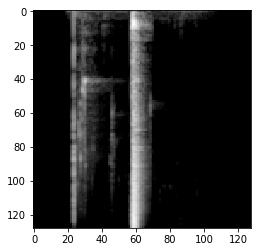

In [20]:
img = Image.fromarray(new_x[2854])
img = np.asarray(img)
plt.imshow(img)

In [21]:
label_num = np.sum(np.vstack((y_train, y_train_noisy, new_y)), axis=0)
print(label_num)

[500 500 623 524 500 500 500 524 500 500 500 500 500 503 500 568 614 500
 500 566 500 500 500 514 527 608 507 500 528 535 500 500 500 526 500 500
 500 500 500 537 575 500 552 500 500 500 500 500 500 500 500 500 500 500
 500 500 500 500 500 500 500 512 500 500 500 500 500 500 574 500 500 500
 500 500 500 500 500 500 500 500]


In [22]:
with open('argument.pickle', mode='wb') as f:
    pickle.dump(new_x, f)
with open('label_argument.pickle', mode='wb') as f:
    pickle.dump(new_y, f) 

In [23]:
#pd.read_csv('label_argument.csv').labels.value_counts()

In [24]:
#create_mel_inputs(test, 'test', check=False)